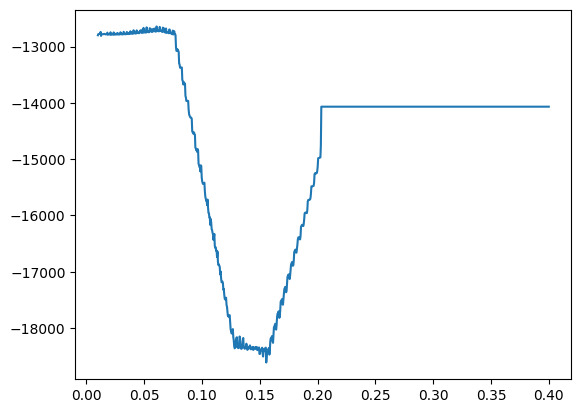

In [1]:
### Preliminaries ###

import jax.numpy as jnp
import jax
import os
import trimesh
import b3d
from b3d import Pose
import rerun as rr
import genjax
from tqdm import tqdm
import demos.differentiable_renderer.likelihood_debugging.demo_utils as du
import demos.differentiable_renderer.likelihood_debugging.model as m
import demos.differentiable_renderer.likelihood_debugging.likelihoods as l
import b3d.differentiable_renderer as r
import numpy as np

# import viser
# server = viser.ViserServer()

# server.add_mesh_simple(
#     name="/patch",
#     vertices=np.array(patch_vertices_P),
#     faces=np.array(patch_faces),
#     # color=np.array(patch_vertex_colors),
#     opacity=0.3
# )

### Preliminaries ###
(
    renderer,
    (observed_rgbds, gt_rots),
    ((patch_vertices_P, patch_faces, patch_vertex_colors), X_WP),
    X_WC
) = du.get_renderer_boxdata_and_patch()


# vetex_colors_with_alpha = jnp.concatenate([patch_vertex_colors, 0.3*jnp.ones((patch_vertex_colors.shape[0], 1))], axis=1)
# import trimesh
# tm = trimesh.Trimesh(
#     vertices = patch_vertices_P,
#     faces = patch_faces,
#     vertex_colors = np.array(vetex_colors_with_alpha)
# )
# server.add_mesh_trimesh(
#     name="/patch",
#     mesh=tm
# )

hyperparams = r.DifferentiableRendererHyperparams(
    3, 1e-5, 1e-2, -1
)

depth_scale = 0.01
mindepth = -1.0
maxdepth = 2.0
likelihood = l.ArgMap(
    l.ImageDistFromPixelDist(
        l.mixture_of_uniform_and_multi_uniformrgb_laplacedepth,
        [True, True, False, False, False]
    ),
    lambda weights, rgbds: ( renderer.height, renderer.width,
                            weights, rgbds, depth_scale, mindepth, maxdepth )
)

model = m.single_object_model_factory(
    renderer,
    likelihood,
    hyperparams
)

key = jax.random.PRNGKey(0)
trace, weight = model.importance(
    key,
    genjax.choice_map({
        "pose": X_WP,
        "camera_pose": X_WC,
        "observed_rgbd": observed_rgbds[0]
    }),
    (patch_vertices_P, patch_faces, patch_vertex_colors, ())
)

rr.init("test")
rr.connect("127.0.0.1:8812")
m.rr_log_trace(trace, renderer, 0.1)

### Generate image samples ###

# def generate_image(key):
#     trace, weight = model.importance(
#         key,
#         genjax.choice_map({ "pose": X_WP, "camera_pose": X_WC }),
#         (patch_vertices_P, patch_faces, patch_vertex_colors, ())
#     )
#     return trace.get_retval()[0]
# images = jax.vmap(generate_image)(jax.random.split(key, 100))
# for i, image in enumerate(images):
#     rr.set_time_sequence("image_sample", i)
#     rr.log(f"/image_sample/rgb", rr.Image(image[:, :, :3]))
#     rr.log(f"/image_sample/depth", rr.DepthImage(image[:, :, 3]))

### Grid over positions and show samples ###
@jax.jit
def get_score(depth):
    pos = jnp.array([X_WP.pos[0], X_WP.pos[1], depth])
    pose = Pose(pos, X_WP.rot)
    trace, weight = model.importance(
        key,
        genjax.choice_map({
            "pose": pose,
            "camera_pose": X_WC,
            "observed_rgbd": observed_rgbds[0]
        }),
        (patch_vertices_P, patch_faces, patch_vertex_colors, ())
    )
    return weight

depths = jnp.linspace(0.01, 0.15 1000)
scores = jnp.stack([get_score(d) for d in depths])
import matplotlib.pyplot as plt
plt.plot(depths, scores)

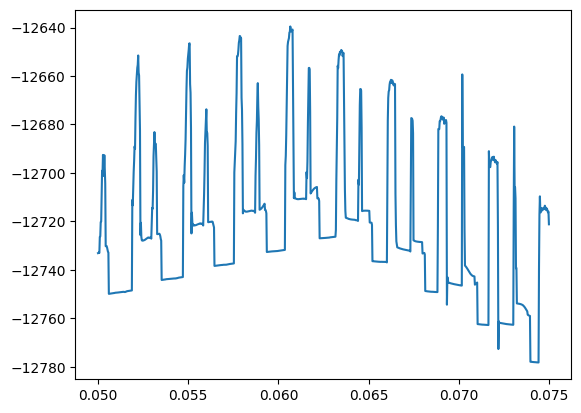

In [7]:
depths = jnp.linspace(0.05, 0.075, 1000)
scores = jnp.stack([get_score(d) for d in depths])
plt.plot(depths, scores)